In [ ]:
def approx_C_weighted(lwe_dataset, hw, params):
    prob = hw / params['n']
    return torch.sum(lwe_dataset.get_A() * prob, dim=1) // params['q']


hws = [10, 15, 20, 25, 30]
seeds = [1, 2, 3, 4, 5]

fig, axs = plt.subplots(len(seeds), len(hws), figsize=(20, 12), constrained_layout=True)

for i, seed in enumerate(seeds):
    for j, hw_val in enumerate(hws):
        params = {
            'n': 50,
            'q': 3329,
            'k': 1,
            'secret_type': 'binary',
            'error_type': 'binary',
            'seed': seed,
            'hw': hw_val
        }

        hw = min(params.get("hw", params['n']), params['n'] // 2)
        dataset = LWEDataset(params)
        dataset.initialize(num_gen=10, add_noise=True, mod_q=True)

        B_long = dataset.get_A() @ dataset.get_secret()
        real_C = B_long // params['q']

        sorted_A, _ = torch.sort(dataset.get_A(), dim=1, descending=True)
        upper_limit = torch.sum(sorted_A[:, :hw], dim=1) // params['q']
        lower_limit = torch.sum(sorted_A[:, -hw:], dim=1) // params['q']

        approx_C = approx_C_weighted(dataset, hw, params)

        ax = axs[i][j]
        ax.hist(lower_limit.numpy(), bins=range(int(lower_limit.min()), int(lower_limit.max()) + 2),
                alpha=0.5, label='lower_limit', edgecolor='black')
        ax.hist(real_C.numpy(), bins=range(int(real_C.min()), int(real_C.max()) + 2),
                alpha=0.5, label='real_C', edgecolor='black')
        ax.hist(upper_limit.numpy(), bins=range(int(upper_limit.min()), int(upper_limit.max()) + 2),
                alpha=0.5, label='upper_limit', edgecolor='black')
        ax.hist(approx_C.numpy(), bins=range(int(approx_C.min()), int(approx_C.max()) + 2),
                alpha=0.5, label='approx_C', edgecolor='black')

        ax.set_title(f"Seed={seed}, hw={hw_val}")
        ax.set_xlabel("Value")
        ax.set_ylabel("Freq")

# Add a single legend for all subplots
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, fontsize='large')

plt.suptitle("Distributions for Different Seeds and hw values", fontsize=18)
plt.show()

In [ ]:
def compute_metrics(real, approx):
    mae = torch.mean(torch.abs(real - approx)).item()
    rmse = torch.sqrt(torch.mean((real - approx) ** 2)).item()
    return mae, rmse

# List of approximation functions
approximations = [approx_C_weighted]

hws = [10, 15, 20, 25, 30]
seeds = [0, 1]

if len(approximations) == 1:
    fig, axs = plt.subplots(len(seeds), len(hws), 
                            figsize=(len(hws) * 5, len(seeds) * 5), constrained_layout=True)
else:
    fig, axs = plt.subplots(len(approximations), len(seeds) * len(hws), 
                            figsize=(len(seeds) * len(hws) * 5, len(approximations) * 5), constrained_layout=True)

for idx, (seed, hw_val) in enumerate([(s, h) for s in seeds for h in hws]):
    params = {
        'n': 50,
        'q': 3329,
        'k': 1,
        'secret_type': 'binary',
        'error_type': 'binary',
        'seed': seed,
        'hw': hw_val
    }

    hw = min(params.get("hw", params['n']), params['n'] // 2)
    dataset = LWEDataset(params)
    dataset.initialize(num_gen=10, add_noise=True, mod_q=True)
    dataset.reduce()

    B_long = dataset.get_A() @ dataset.get_secret()
    real_C = B_long // params['q']

    # List to hold the RMSE for each approximation
    rmse_values = []

    # Loop through each approximation function and compute the metrics
    for approx_idx, approx_func in enumerate(approximations):
        approx_C = approx_func(dataset, hw, params)

        # Compute metrics
        mae, rmse = compute_metrics(real_C, approx_C)
        rmse_values.append(rmse)

        # Determine subplot index
        if len(approximations) == 1:
            ax = axs[seed][hws.index(hw_val)]
        else:
            ax = axs[approx_idx][idx]

        # Plot the approximations
        ax.hist(real_C.numpy(), bins=range(int(real_C.min()), int(real_C.max()) + 2),
                 alpha=0.5, label='real_C', edgecolor='black')
        ax.hist(approx_C.numpy(), bins=range(int(approx_C.min()), int(approx_C.max()) + 2),
                 alpha=0.5, label=f'approx_{approx_idx + 1}', edgecolor='black')
        ax.set_title(f"Seed={seed}, hw={hw_val}\n")
        ax.set_xlabel("Value")
        ax.set_ylabel("Freq")

        text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}"
        ax.text(0.95, 0.95, text,
                 transform=ax.transAxes, fontsize=10, ha='right', va='top',
                 bbox=dict(facecolor='white', alpha=0.8))

    # Identify the best approximation based on RMSE
    best_approx_idx = rmse_values.index(min(rmse_values))

    # Re-plot the best approximation in red
    best_approx_func = approximations[best_approx_idx]
    best_approx_C = best_approx_func(dataset, hw, params)

    # Re-plot the best approximation in red
    if len(approximations) == 1:
        ax = axs[seed][hws.index(hw_val)]
    else:
        ax = axs[best_approx_idx][idx]
    ax.hist(real_C.numpy(), bins=range(int(real_C.min()), int(real_C.max()) + 2),
             alpha=0.5, label='real_C', edgecolor='black')
    ax.hist(best_approx_C.numpy(), bins=range(int(best_approx_C.min()), int(best_approx_C.max()) + 2),
             alpha=0.5, label=f'approx_{best_approx_idx + 1} (Best)', edgecolor='red', color='red')

# Add legends once
handles, labels = axs[0][0].get_legend_handles_labels() if len(approximations) > 1 else axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize='large')

plt.suptitle("real_C vs Approximations (Best Approximation in Red)", fontsize=18)
plt.show()

In [ ]:
n_epochs = 20000
lr = 1e-3
check_every = 100
# Check if GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LinearComplex(params).to(device)
model.train()

A = dataset.A.to(device)
b = dataset.B.to(device)

A_reduced = dataset.get_A().to(device)
best_b = torch.tensor(dataset.best_b_candidates).to(device)

b_real = b_real.to(device)

b_candidates = dataset.b_candidates
b_probs = dataset.b_probs

# Create a mask to only use the best candidates
#A_reduced = A_reduced[mask]
#best_b = best_b[mask]

loss_history = []
lookback = 10
min_decrease = -1

# Get the secret from the dataset
secret = dataset.get_secret()
secret = secret.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

for epoch in range(1, n_epochs + 1):    
    optimizer.zero_grad()

    pred_b = model(A_reduced)
    b_loss = loss_fn(pred_b, best_b)
        
    b_loss.backward()
    optimizer.step()

    loss_history.append(b_loss.item())
    print(f"Epoch {epoch}/{n_epochs}, Loss: {b_loss.item():.4f}")
    
    if epoch % check_every == 0:
        with torch.no_grad():
            guessed_secret = clean_secret(model.guessed_secret, params)
            if check_secret(guessed_secret, A, b, params):
                print(f"Secret guessed correctly at epoch {epoch}!")
                break

    # if we detect stalling, *recompute* best_b via gradient–scoring …
    if len(loss_history) > lookback and \
       (np.mean([loss_history[i] - loss_history[i-1] 
                 for i in range(-lookback, 0)]) > min_decrease):
        print(f"Stalling detected at epoch {epoch}.")
        
        model.eval()

        # Calculate the full gradient as a weighted average of gradients based on probabilities
        full_grad = torch.zeros_like(model.guessed_secret.grad, device=device)

        for i in range(len(A_reduced)):
            # Find index of best candidate (by probability)
            best_idx = torch.where(b_candidates[i].to(device) == best_b[i])[0].item()
            best_vec = b_candidates[i][best_idx]
            best_prob = b_probs[i][best_idx]

            # Compute gradient of model w.r.t. best bᵢ
            Ai = A_reduced[i].unsqueeze(0)               # [1, ...]
            bi = best_vec.unsqueeze(0).to(device)            # [1, D]
            prob = best_prob.unsqueeze(0).to(device)         # [1]

            model.zero_grad()
            pred = model(Ai)
            loss = F.mse_loss(pred, bi)
            loss.backward()

            grad = model.guessed_secret.grad.detach().clone()

            full_grad += prob * grad

        
        for i in range(len(A_reduced)):
            Ai = A_reduced[i]
            vec_candidates = b_candidates[i]
            prob_candidates = b_probs[i]

            cos_sim_vec = torch.zeros(len(vec_candidates), dtype=torch.float)

            for j, (b_vec, prob) in enumerate(zip(vec_candidates, prob_candidates)):
                # 1) Compute the gradient for the current candidate
                model.zero_grad()
                b_vec = b_vec.to(device)
                pred_b = model(Ai.unsqueeze(0))
                b_loss = loss_fn(pred_b, b_vec.unsqueeze(0))
                b_loss.backward()
                
                # 2) Compute the gradient for the current candidate
                grad_i = model.guessed_secret.grad.detach().clone()

                cos_sim = F.cosine_similarity(grad_i.unsqueeze(0), full_grad.unsqueeze(0), dim=1).item()
                cos_sim_vec[j] = cos_sim

            score = prob_candidates * cos_sim_vec
            max_score_indices = torch.where(score == torch.max(score))[0]
            if len(max_score_indices) > 1:
                # If there are multiple max scores, choose the one with the highest probability
                best_index = max_score_indices[torch.argmax(prob_candidates[max_score_indices])]
            else:
                best_index = max_score_indices[0]
                
            best_vec = vec_candidates[best_index]

            best_b[i] = best_vec
        loss_history = []
        
        count_best_b_in_b_real = sum(best_b == b_real).item()
        print(f"Number of best_b in b_real: {count_best_b_in_b_real} / {len(b_real)} ({100 * count_best_b_in_b_real / len(b_real):.2f}%)")

        model.train()
       

In [ ]:
lr = 1e-3
check_every = 100

# Check if GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearComplex(params).to(device)
loss_fn = nn.MSELoss()

A_reduced = dataset.get_A().to(device)
best_b = torch.tensor(dataset.best_b_candidates).to(device)

b_real = b_real.to(device)

b_candidates = dataset.b_candidates
b_probs = dataset.b_probs

epoch = 0

while True:
    # 1) Train until stall
    loss, epoch = train_until_stall(model, A_reduced, best_b, dataset, epoch=epoch)
    if loss == 0:
        print("Secret guessed correctly at epoch {}!".format(epoch))
        break
    print(f"Stalling detected at loss {loss:.4f}.")
    
    model.eval()

    # 2) Calculate the full gradient as a weighted sum of gradients based on probabilities
    full_grad = torch.zeros_like(model.guessed_secret.grad, device=device)

    for i in range(len(A_reduced)):
        # Find index of best candidate (by probability)
        best_idx = torch.where(b_candidates[i].to(device) == best_b[i])[0].item()
        best_vec = b_candidates[i][best_idx]
        best_prob = b_probs[i][best_idx]

        # Compute gradient of model w.r.t. best bᵢ
        Ai = A_reduced[i].unsqueeze(0)               # [1, ...]
        bi = best_vec.unsqueeze(0).to(device)            # [1, D]
        prob = best_prob.unsqueeze(0).to(device)         # [1]

        model.zero_grad()
        pred = model(Ai)
        loss = F.mse_loss(pred, bi)
        loss.backward()

        grad = model.guessed_secret.grad.detach().clone()

        full_grad += prob * grad

    # Normalize the full gradient
    full_grad /= torch.norm(full_grad)

    # 3) Find the worst‐aligned indices
    cos_sim_vec = torch.zeros(len(best_b), device=device)
    for i, b_vec in enumerate(best_b):
        model.zero_grad()
        pred = model(A_reduced[i].unsqueeze(0))
        mse = loss_fn(pred, b_vec.unsqueeze(0))
        mse.backward()
        grad_i = model.guessed_secret.grad.detach()
        cos_sim_vec[i] = F.cosine_similarity(grad_i.unsqueeze(0), full_grad.unsqueeze(0), dim=1)
    worst_idxes = torch.topk(cos_sim_vec, k=5, largest=False).indices
    print(f"Worst indexes: {worst_idxes.tolist()} | sims: {cos_sim_vec[worst_idxes].tolist()}")

    model_snapshot = copy.deepcopy(model.state_dict())
    
    # 2) prepare per-index candidate‐vectors
    cand_lists = []
    for idx in worst_idxes:
        cand_lists.append([vec.to(device) for vec in b_candidates[idx]])

    # 3) loop over every full combination
    best_combo_loss = float('inf')
    best_combo = None

    for combo in itertools.product(*cand_lists):
        # overwrite that position in best_b
        trial_b = best_b.clone()
        for idx, new_vec in zip(worst_idxes, combo):
            trial_b[idx] = new_vec

        # restore model & optimizer
        model.load_state_dict(model_snapshot)

        # retrain on trial_b until stall
        loss_combo, epoch_combo = train_until_stall(model, A_reduced, trial_b, dataset, verbose=False)

        print(f"Combo {[vec.tolist() for vec in combo]}: loss {loss_combo:.4f} | epoch {epoch_combo} | progress: {(trial_b == b_real).sum().item()}/{len(b_real)} correct")

        if 0 < loss_combo < best_combo_loss:
            best_combo_loss = loss_combo
            best_combo = combo

    # 4) commit the best joint swap
    if best_combo is not None:
        for idx, new_vec in zip(worst_idxes, best_combo):
            best_b[idx] = new_vec
        print(f"→ Applied joint swap on indices {worst_idxes.tolist()} with stall_loss {best_combo_loss:.4f}")
    else:
        print("No multi‐swap improved stall_loss; keeping old best_b")

    # restore model & optimizer to snapshot + that one swap
    model.load_state_dict(model_snapshot)
        
    # 5) Report progress and save best_b
    count_correct = (best_b == b_real).sum().item()
    pct = 100 * count_correct / len(b_real)
    print(f"Progress: {count_correct}/{len(b_real)} correct ({pct:.2f}%)\n")
    # loop goes back to train_until_stall with updated best_b

       

EM algorithm (did not work, it decrease loss, but also percentage of real b)

In [ ]:
A_reduced = dataset.get_A()
best_b = dataset.best_b_candidates

# Check if GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
A_reduced = torch.tensor(A_reduced, dtype=torch.float).to(device)
best_b = torch.tensor(best_b, dtype=torch.float).to(device)

for _ in range(1000):
    epoch = 0
    model = LinearComplex(dataset.params).to(device)
    
    loss, epoch = train_until_stall(model, A_reduced, best_b, dataset, epoch=epoch, verbose=False)
    if loss == 0:
        print("Secret guessed correctly at epoch {}!".format(epoch))
    else:
        print(f"Stalling detected at loss {loss:.4f}. Continuing training...")

    # Updating best_b using EM algorithm
    with torch.no_grad():
        c = torch.round((model(A_reduced) - best_b) / model.q).long()
        best_b += c * model.q

        # Calculate and print the percentage of best_b values that match b_real
        matches = (best_b.cpu().numpy() == b_real).sum()
        percentage = 100 * matches / len(b_real)
        print(f"Percentage of best_b in b_real: {percentage:.2f}%")

In [ ]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from ml_attack.utils import calculate_min_trials
import math 

m = 300
n = 4
factor = 0.875
k = 1

n = int(m * factor * k)
print("n:", m)
print("m:", n)

#print("Min trials:", calculate_min_trials(n=n*samples, m=m))

min_samples = int((m*k + n)) * 64 - 1
print("Min samples:", min_samples)
print("Min matrices:", min_samples // (n + m * k) + 1)

n: 300
m: 262
Min samples: 35967
Min matrices: 64


In [ ]:
from estimator import *

# Define parameters
m = 256 * 2
n = int(m * 0.875)
q = 3329
Xs = ND.CenteredBinomial(2)
Xe = ND.CenteredBinomial(2)
# Pack parameters
params = LWE.Parameters(n=m, q=q, Xs=Xs, Xe=Xe, m=n)

print(params)

# Estimate security using primal-usvp attack
result = LWE.dual(params)
print(result)

LWEParameters(n=512, q=3329, Xs=D(σ=1.00), Xe=D(σ=1.00), m=448, tag=None)
         rop: ≈2^143.1
         mem: ≈2^92.3
           m:      448
           β:      400
           d:      960
           ↻:        1
         tag:     dual


In [189]:
import numpy as np

import numpy as np

def lattice_volume(B):
    gram = B.T @ B
    return np.sqrt(np.linalg.det(gram))

# Ensure m is integer for matrix dimensions
m = 4
n = 3
q = 3329
# Set penalty value (choose a reasonable integer, e.g., 1 or another value as needed)
penalty = 4

# Create random matrix A of shape (m, n) with entries in [0, q)
A = np.random.randint(0, q, size=(m, n), dtype=int)

# SALSA configuration
A_red = np.zeros((m + n, m + n), dtype=int)
A_red[n:, :m] = np.identity(m, dtype=int) * penalty
A_red[:n, m:] = np.identity(n, dtype=int) * q
A_red[n:, m:] = A

print("A reduced matrix (A_red):")
print(A_red)

# Calculate the volume of the lattice
volume = lattice_volume(A_red)
print("Volume of the lattice:", volume)

# Other configuration
A_red = np.zeros((m + n, m + n), dtype=int)
A_red[:m, :m] = np.identity(m, dtype=int) * penalty
A_red[:m, m:] = A
A_red[m:, m:] = np.identity(n, dtype=int) * q

print("A reduced matrix (A_red):")
print(A_red)

# Calculate the volume of the lattice
volume = lattice_volume(A_red)
print("Volume of the lattice:", volume)

# Other configuration
A_red = np.zeros((m + n, m + n), dtype=int)
A_red[:m, :n] = A
A_red[:m, n:] = np.identity(m, dtype=int) * penalty
A_red[m:, :n] = np.identity(n, dtype=int) * q

print("A reduced matrix (A_red):")
print(A_red)

# Calculate the volume of the lattice
volume = lattice_volume(A_red)
print("Volume of the lattice:", volume)

calc_det = q**n * penalty**m
print("Calculated determinant:", calc_det)

A reduced matrix (A_red):
[[   0    0    0    0 3329    0    0]
 [   0    0    0    0    0 3329    0]
 [   0    0    0    0    0    0 3329]
 [   4    0    0    0 1903  260 2803]
 [   0    4    0    0 3016  763 1255]
 [   0    0    4    0 2272 1920 1673]
 [   0    0    0    4 2601 1536  509]]
Volume of the lattice: 9444551753984.018
A reduced matrix (A_red):
[[   4    0    0    0 1903  260 2803]
 [   0    4    0    0 3016  763 1255]
 [   0    0    4    0 2272 1920 1673]
 [   0    0    0    4 2601 1536  509]
 [   0    0    0    0 3329    0    0]
 [   0    0    0    0    0 3329    0]
 [   0    0    0    0    0    0 3329]]
Volume of the lattice: 9444551753984.018
A reduced matrix (A_red):
[[1903  260 2803    4    0    0    0]
 [3016  763 1255    0    4    0    0]
 [2272 1920 1673    0    0    4    0]
 [2601 1536  509    0    0    0    4]
 [3329    0    0    0    0    0    0]
 [   0 3329    0    0    0    0    0]
 [   0    0 3329    0    0    0    0]]
Volume of the lattice: 9444551753983.98

In [ ]:
R = A_red[:m, :]
print(f"R shape: {R.shape}")
print("R matrix:")
print(R)
R.T@A

R shape: (4, 7)
R matrix:
[[  3   0   0   0 233 193 239]
 [  0   3   0   0 105 221 204]
 [  0   0   3   0 155  26  36]
 [  0   0   0   3  45  68 192]]


array([[   699,    579,    717],
       [   315,    663,    612],
       [   465,     78,    108],
       [   135,    204,    576],
       [ 91364,  75264,  91327],
       [ 75264,  91390, 105203],
       [ 91327, 105203, 136897]])

In [3]:
import math
from scipy.special import erf, erfinv

def min_stddev_for_success_probability(p: float, q: float) -> float:
    """
    Compute the minimum standard deviation of LWE noise (e)
    such that Pr[|e| < q/2] = p, where e ~ N(0, sigma^2).
    
    Parameters:
    - p: desired success probability (0 < p < 1)
    - q: modulus (positive number)
    
    Returns:
    - sigma: minimum standard deviation
    """
    if not (0 < p < 1):
        raise ValueError("Probability p must be between 0 and 1 (exclusive).")
    if q <= 0:
        raise ValueError("Modulus q must be positive.")

    sigma = q / (2 * math.sqrt(2) * erfinv(p))
    return sigma

# Example usage:
q = 3329
p = 0.85
sigma = min_stddev_for_success_probability(p, q)
print(f"Minimum standard deviation σ for p = {p} and q = {q} is approximately {sigma:.4f}")


Minimum standard deviation σ for p = 0.85 and q = 3329 is approximately 1156.2790


In [ ]:
import math
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from ml_attack import LWEDataset
import numpy as np

# Example usage
m = 140
q = 3329
w = 4
delta_0 = 1.01
gamma = 0.875

d = (1 + gamma) * m
exponent_w = 1 / (1 + gamma)
exponent_q = gamma / (1 + gamma)

lambda_1 = (delta_0 ** d) * (w ** exponent_w) * (q ** exponent_q)

print(f"λ₁ ≈ {lambda_1:.2f}")

#frob_RA = lambda_1 * q * n * math.sqrt((1 + gamma) * gamma / 12)
#frob_RA = lambda_1 * math.sqrt(gamma * n * (1 + gamma)*n) * q / math.sqrt(12)
n = int(gamma * m)
frob_RA = lambda_1 * q * math.sqrt(n) / (math.sqrt(12)* (m+n))
print(f"Frobenius norm of R^T A: {frob_RA:.2f}")

dataset = LWEDataset.load_reduced("./../data/data_n_128_k_1_s_binary_ee734.pkl")
print("Dataset loaded.")

# Print the norm of each R sample (row-wise)
R_norm = np.linalg.norm(R[0])
print(R_norm)

std_RA = R_norm / math.sqrt(12) * q
print(f"Frobenius norm of R^T A: {std_RA:.2f}")

RA = dataset.RA
# Calculate the Frobenius norm of R @ A using numpy
frob_RA_actual = np.std(RA[0])
print(f"Actual Frobenius norm of R*A: {frob_RA_actual}")

λ₁ ≈ 1004.56
Frobenius norm of R^T A: 42569.23
Dataset loaded.
475.0852555068406
Frobenius norm of R^T A: 456556.70
Actual Frobenius norm of R*A: 596.6702847049636


### Best number of samples m

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from ml_attack.utils import get_vector_distribution
from scipy.special import erf

m = 128
q = 3329
w = 4
b = 90
eta = 2
phi = 6

params = {'n': m, 'eta': eta}

delta_0 = (b / (2 * np.pi * np.e) * (b * np.pi ) ** (1 / b)) ** (1/(2*(b-1)))
print(f"delta_0: {delta_0:.4f}")

n = int(np.sqrt(m * (np.log(q) - np.log(w)) / np.log(delta_0)) - m)
print(f"Best number of samples m: {n}")

d = m + n
print(f"Total dimension d: {d}")

v = delta_0 ** d * np.exp((m * np.log(q) + n * np.log(w)) / d)
_, var_s, _ = get_vector_distribution(params, vector_type='cbd')
_, var_e, _ = get_vector_distribution(params, vector_type='cbd')
print(f"v: {v:.4f}")
print(f"var_s: {var_s:.4f}")
print(f"var_e: {var_e:.4f}")

factor = (var_e + phi * var_s) / (w**2 + phi)
print(f"Factor: {factor:.4f}")

p = erf(q / (2 * np.sqrt(2*factor) * v))
print(f"Probability p: {p:.4f}")

delta_0: 1.0093
Best number of samples m: 156
Total dimension d: 284
v: 1877.2865
var_s: 1.0000
var_e: 1.0000
Factor: 0.0660
Probability p: 0.9994


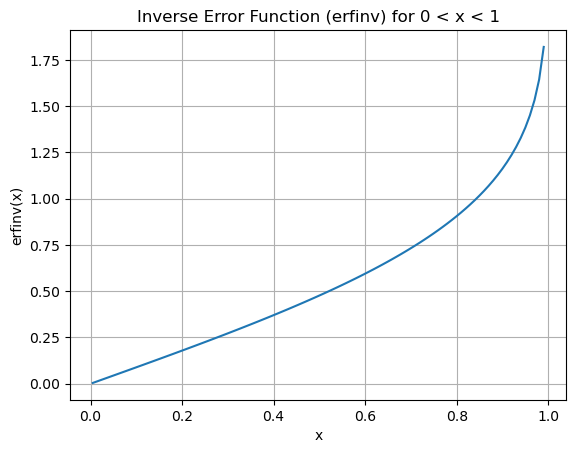

In [4]:
from scipy.special import erfinv
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 200)
y = erfinv(x)

plt.plot(x[(x > 0) & (x < 1)], y[(x > 0) & (x < 1)])
plt.xlabel("x")
plt.ylabel("erfinv(x)")
plt.title("Inverse Error Function (erfinv) for 0 < x < 1")
plt.grid(True)
plt.show()